In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import hashlib
import numpy as np
from matplotlib import rc
from ProjectAnalysis import ProjectAnalysis
pd.set_option('display.max_colwidth', -1)

In [2]:
project="Lang"
experiment=2

In [3]:
pa = ProjectAnalysis(project,  experiment)

## Calculate the number of builds of each type

In [4]:
pa.stats()

TOTAL: 3570
SUCCESS: 2789
FAIL: 781
SUCCESS RATIO: 78.12324929971989%
FAIL RATIO: 21.876750700280112%


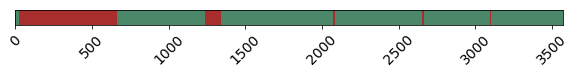

In [5]:
pa.plot_and_save_histogram(1)

## Collect all fails, separate them into groups and get the logs of each commit with build fail

In [6]:
fails, groups_of_fails = pa.get_fails_and_grouped_fails()
groups_of_fails.reverse()

## Group the commits by their logs

In [7]:
DEV="DEVELOPER_ERROR"
CONTX="CONTEXT_ERROR"
ND="NOT_DETECTED"
symptom_templates = [
    # CONTEXT ERRORS
        # ADDED WITH LANG
        ('error: unmappable character for encoding UTF8', CONTX),
        ('error: as of release 5, \'enum\' is a keyword, and may not be used as an identifier', CONTX),
        ('error: no suitable method found for append\(char\[\]\)', CONTX),
        # ADDED WITH MATH
        ('Error opening connection (.+)', CONTX),
        # ADDED WITH MOCKITO
        ('Could not find (.+)', CONTX),
        ('Could not compile build file (.+)', CONTX),
        ('Cannot get property \'tasks\' on null object', CONTX),
        ('There were failing tests.', CONTX),
        ('Exception in thread "main" java.io.FileNotFoundException: (.+)', CONTX),
        ('Could not resolve all dependencies (.+)', CONTX),
        ('FileNotFoundException: (.+)', CONTX)
    
]+[
    # DEVELOPER ERRORS
        # ADDED WITH LANG
        ('(error: cannot find symbol)(?:.*\n)*.*symbol: (.*)',DEV,[1,2]),
        ('build.xml:1: Content is not allowed in prolog.', DEV),
        #('(.+)\.java:\[\d+,\d+\] error: cannot find symbol (.*)',"SSS",[1,2]),
        # ADDED WITH MOCKITO,
        ('unable to resolve class (.+)', DEV),
        ('Type Improvement not present', DEV)
        
]+[
    # COMMON ERRORS
        # ADDED WITH LANG
        ('\[ERROR\] .*\.java:\[\d+,\d+\] (.+)', DEV,[1]),
        ('error: (.+)', DEV),
        # ADDED WITH MOCKITO
        ("What went wrong:\n(.+)", DEV),
        # ADDED WITH MATH
        ("BUILD FAILED\n(.*)", DEV),
        ("\[ERROR\] (.*)", DEV),
        ("there is no POM in this directory", ND),
        # ADDED WITH MATH
        ('Failed to execute goal (\S+)', DEV),
]

In [8]:
errors = pa.group_errors_by_log(fails, symptom_templates)
print("Number of errors: %d"%len(errors))
print("Number of groups: %d"%len(groups_of_fails))

Number of errors: 19
Number of groups: 20


In [9]:
# Trazas de error agrupadas
errors_df = pd.DataFrame.from_dict(errors, orient='index')
errors_df = errors_df.sort_values(by=['count'], ascending=False)
errors_df = errors_df[['trace','type', 'count']]
errors_df.to_csv("%s/%s_errors.tsv"%(pa.path, pa.project), sep='\t', encoding='utf-8', index=False)
print("Saved at %s_errors.tsv"%pa.project)
errors_df

Saved at Lang_errors.tsv


,trace,type,count
8c9a61e569504289e9c6b17d8d1bf829,error: unmappable character for encoding UTF8,CONTEXT_ERROR,474
1a8c2eecee81eb655b47e5bd09016a3c,"error: as of release 5, 'enum' is a keyword, and may not be used as an identifier",CONTEXT_ERROR,162
d1b28270a5c1c424bb429361faedc15c,error: no suitable method found for append(char[]),CONTEXT_ERROR,106
66eb9f223332d42c2ae312408c746f11,error: cannot find symbol,DEVELOPER_ERROR,9
eda3012a0ad35cb8171a49c1b4cff3fb,error: cannot find symbol class UnhandledException,DEVELOPER_ERROR,6
55f75185b4ce632ff325a7ae0d87f097,error: cannot find symbol class NullArgumentException,DEVELOPER_ERROR,5
4e5f7034fb1f14a046b5643cc360b10f,error: incompatible types: Constructor<?>[] cannot be converted to Constructor<T>[],DEVELOPER_ERROR,2
6d324ddea319521c900649c5f0ff179d,error: variable options might not have been initialized,DEVELOPER_ERROR,2
1ce85102744fbcc9e1b9ec80cba20671,error: cannot find symbol class IDKey,DEVELOPER_ERROR,2
722ff9d3d59f5046e9b3f74a2e6d1ddf,"error: cannot find symbol method appendIdentityToString(StringBuffer,Object)",DEVELOPER_ERROR,2


In [10]:
#pa.view_log_by_hash(errors,"35af87301d9e4dbc0856be7aec1a0926", 0)

In [11]:
errors_df.groupby(errors_df['type']).sum()

,count
type,
CONTEXT_ERROR,742
DEVELOPER_ERROR,38
NOT_DETECTED,1


In [12]:
context_errors_count = errors_df[errors_df['type']=="CONTEXT_ERROR"]['count'].sum()
dev_errors_count = errors_df[errors_df['type']=="DEVELOPER_ERROR"]['count'].sum()
no_build_system_errors_count = errors_df[errors_df['type']=="NOT_DETECTED"]['count'].sum()
total_errors_count = errors_df['count'].sum()

print("CONTEXT_ERRORS %f"%((context_errors_count/total_errors_count)*100))
print("DEVELOPER_ERRORS %f"%((dev_errors_count/total_errors_count)*100))
print("NOT_DETECTED %f"%((no_build_system_errors_count/total_errors_count)*100))

CONTEXT_ERRORS 95.006402
DEVELOPER_ERRORS 4.865557
NOT_DETECTED 0.128041


In [13]:
# Errors by group (group = consecutive failed commits between two SUCCESS commits)
# -> Traces: Identifier-Hash of the different traces of error found in the same group
stripes = []
for idx, g in enumerate(groups_of_fails):
    error_types = []
    error_traces = []
    current_sub_group = ("",0)
    for commit in g:
        if commit['type'] not in error_types:
            error_types.append(commit['type'])
        
        if current_sub_group[0] == commit['hash']:
            current_sub_group = (current_sub_group[0], current_sub_group[1] + 1)
        else:
            if current_sub_group[0] != "": # FIRST
                error_traces.append(current_sub_group)
            current_sub_group = (commit['hash'],1)
    # ADD LAST GROUP
    error_traces.append(current_sub_group)
    seperator = ', '
    error_types = seperator.join(error_types)
    stripes.append([len(g), error_types, error_traces])
df = pd.DataFrame(stripes, columns=['Count', 'Error type', 'Traces'])
df

,Count,Error type,Traces
0,1,NOT_DETECTED,"[(a895d834a1be13e5923f9d07b534b2bb, 1)]"
1,636,CONTEXT_ERROR,"[(8c9a61e569504289e9c6b17d8d1bf829, 474), (1a8c2eecee81eb655b47e5bd09016a3c, 162)]"
2,2,DEVELOPER_ERROR,"[(7e87eb1a28d67e7baa767b31742e7628, 2)]"
3,106,CONTEXT_ERROR,"[(d1b28270a5c1c424bb429361faedc15c, 106)]"
4,1,DEVELOPER_ERROR,"[(8981782c01b07c7a051e34808c3edd99, 1)]"
5,2,DEVELOPER_ERROR,"[(ed45700600ee60d6e9f48d3f85a771c7, 2)]"
6,1,DEVELOPER_ERROR,"[(42a615a7097fbe70021105f85292c0b2, 1)]"
7,1,DEVELOPER_ERROR,"[(2e38940d63562835bb22eb0590ea14fb, 1)]"
8,2,DEVELOPER_ERROR,"[(1ce85102744fbcc9e1b9ec80cba20671, 2)]"
9,2,DEVELOPER_ERROR,"[(722ff9d3d59f5046e9b3f74a2e6d1ddf, 2)]"


In [14]:
# RQ3: MEAN, MAX AND AVERAGE - INTERNAL ERRORS 
def getDuration(hash_key):
    return len(errors[hash_key]['commits'])
def mean(arr):
    return sum(arr) / len(arr) 

durantions=[]
for stripes in df.values.tolist():
    errors_in_same_stripe = stripes[2]   
    for error_hash in errors_in_same_stripe:
        if errors_df.to_dict()['type'][error_hash[0]] == "DEVELOPER_ERROR":
            durantions.append(error_hash[1])

print("MEAN: ",mean(durantions))
print("MAX: ",max(durantions))
print("MIN: ",min(durantions))



MEAN:  2.0
MAX:  6
MIN:  1


In [15]:
# RQ4: MEAN, MAX AND AVERAGE - CONTEXT ERRORS 
durantions=[]
for stripes in df.values.tolist():
    errors_in_same_stripe = stripes[2]   
    for error_hash in errors_in_same_stripe:
        if errors_df.to_dict()['type'][error_hash[0]] =="CONTEXT_ERROR":
            durantions.append(error_hash[1])

print("MEAN: ",mean(durantions))
print("MAX: ",max(durantions))
print("MIN: ",min(durantions))

MEAN:  247.33333333333334
MAX:  474
MIN:  106


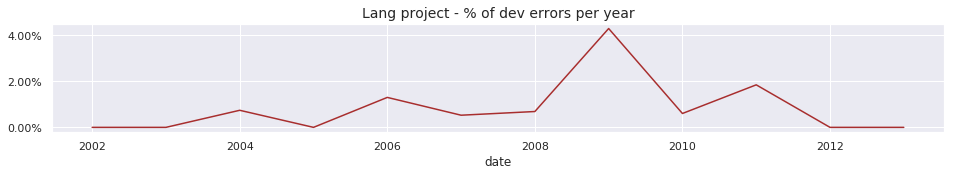

In [16]:
# Number of commits by years, segmented by type of failure
def getType(commit):
    if 'type' in pa.csvDict[commit]:
        return pa.csvDict[commit]['type']
    else:
        return 'SUCCESS'

import seaborn as sns
plt.rcParams["figure.figsize"] =[10.0, 2.0]
sns.set()
sns.set_palette([
    '#f2711c', 
    '#a82e2e', 
    '#909090', 
    '#4b8869'
])
commits = pa.data.copy()
commits['type'] = commits.apply(lambda x: getType(x['commit']), axis=1)
# commits.groupby(commits['date'].dt.year).type.value_counts().unstack('type')
# commits.plot(kind='line', stacked=True)
# plt.show()

df = commits.groupby(commits['date'].dt.year).type.value_counts()
df = df.groupby(level=0).apply(lambda x: x / float(x.sum()))
df = df.unstack('type').fillna(0)
df = df['DEVELOPER_ERROR']
ax = df.plot(figsize=(16, 2), color="#a82e2e")
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
plt.title("%s project - %% of dev errors per year"%pa.project, fontsize=14)
df.to_csv("%s/%s_dev_errors.tsv"%(pa.path, pa.project), sep='\t', encoding='utf-8')
plt.savefig("%s/%s_dev_errors.png"%(pa.path, pa.project),bbox_inches='tight')
plt.show()

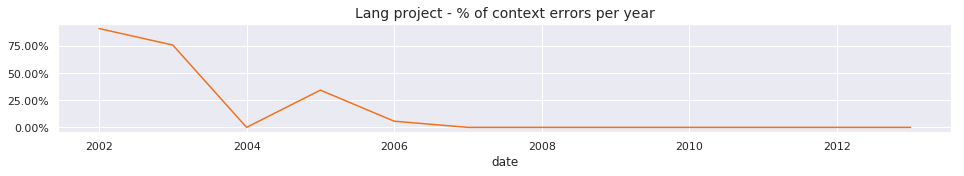

date
2002    0.907749
2003    0.755814
2004    0.000000
2005    0.341912
2006    0.056522
2007    0.000000
2008    0.000000
2009    0.000000
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.000000
Name: CONTEXT_ERROR, dtype: float64

In [17]:
df = commits.groupby(commits['date'].dt.year).type.value_counts()
df = df.groupby(level=0).apply(lambda x: x / float(x.sum()))
df = df.unstack('type').fillna(0)
df = df['CONTEXT_ERROR']
ax = df.plot(figsize=(16, 2), color="#f2711c")
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
plt.title("%s project - %% of context errors per year"%pa.project, fontsize=14)
df.to_csv("%s/%s_context_errors.tsv"%(pa.path, pa.project), sep='\t', encoding='utf-8')
plt.savefig("%s/%s_context_errors.png"%(pa.path, pa.project),bbox_inches='tight')
plt.show()
df

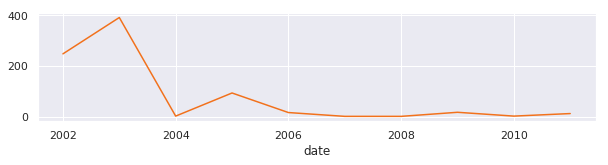

In [18]:
# Nº de commits erroneos por años (CONTEXT_ERROR + DEVELOPER_ERROR + NOT_DETECTED)
f_commits = commits[(commits['build'] == 'FAIL')].copy()
f_commits.groupby(f_commits['date'].dt.year).type.count().plot()
plt.show()

In [19]:
import os
build_files = [f for f in os.listdir(pa.path+"/build_files/") if re.match(r'.*\.json', f)]
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)-.*', text) ]
build_files.sort(key=natural_keys)

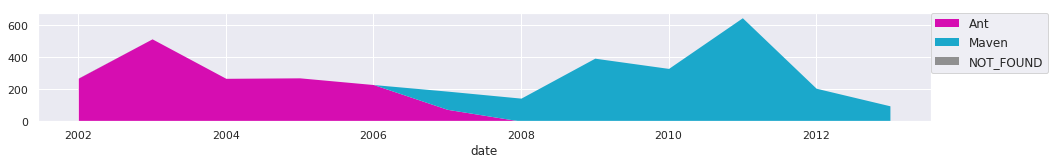

In [20]:
import json
sns.set_palette([
    '#d60db1', # MORADO - ANT
    '#1BA8CB', # AZUL - GRADLE/MAVEN
    '#909090'
])
def getBuildSystem(id_, commit):
    with open(pa.path+"/build_files/%d-%s-build.json"%(id_, commit)) as f: 
        build_file = json.load(f)
    return build_file['build_system']
commits['build_system'] = commits.apply(lambda x: getBuildSystem(x['id'],x['commit']), axis=1)
(commits.groupby(commits['date'].dt.year).build_system.value_counts().unstack('build_system')
.plot(kind='area', stacked=True, figsize=(16, 2), linewidth=0))
lgd=plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., prop={'size': 12})
plt.savefig("%s/%s_build_systems-1.png"%(pa.path, pa.project),bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

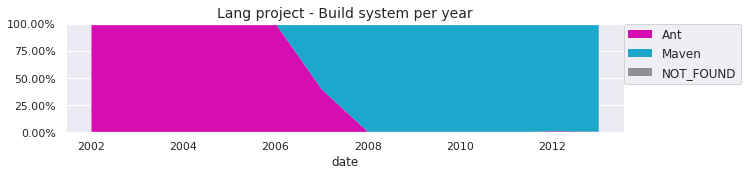

build_system,Ant,Maven,NOT_FOUND
date,,,
2002,0.996310,0.000000,0.00369
2003,1.000000,0.000000,0.00000
2004,1.000000,0.000000,0.00000
2005,1.000000,0.000000,0.00000
2006,1.000000,0.000000,0.00000
2007,0.396825,0.603175,0.00000
2008,0.006897,0.993103,0.00000
2009,0.002532,0.997468,0.00000
2010,0.000000,1.000000,0.00000


In [21]:
data = commits.groupby(commits['date'].dt.year).build_system.value_counts().unstack('build_system')
data = data.fillna(0)
data_perc = data.divide(data.sum(axis=1), axis=0)

ax=data_perc.plot(kind='area', stacked=True, linewidth=0)
plt.ylim((0,1))
lgd=plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., prop={'size': 12})
plt.title("%s project - Build system per year"%pa.project, fontsize=14)
plt.savefig("%s/%s_build_systems-2.png"%(pa.path, pa.project),bbox_extra_artists=(lgd,), bbox_inches='tight')
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
plt.show()
data_perc 

In [22]:
def plot_and_save_histogram_advance(pa,jump):
    total_commits = len(pa.df())+jump
    limit = len(pa.df())

    data = pa.df()

    dev_list=[]
    context_list=[]
    grey_list=[]
    success_list=[]
    for _,row in data.iterrows():
        if row['build'] == "SUCCESS":
            success_list.append(len(data)-int(row['id'])-1)
        else:
            if pa.csvDict[row['commit']]['type'] == "DEVELOPER_ERROR":
                dev_list.append(len(data)-int(row['id'])-1)
            if pa.csvDict[row['commit']]['type'] == "CONTEXT_ERROR" or pa.csvDict[row['commit']]['type'] == "NOT_DETECTED":
                context_list.append(len(data)-int(row['id'])-1)

    bins = np.arange(0,total_commits,jump)

    fig, ax = plt.subplots(figsize=(8, 2))
    _, bins, patches = plt.hist([   np.clip(success_list, bins[0], bins[-1]),
                                    np.clip(dev_list, bins[0], bins[-1]),
                                    np.clip(context_list, bins[0], bins[-1])
                                ],
                                    #normed=1,  # normed is deprecated; replace with density
                                    stacked=True,
                                    #density=True,
                                    bins=bins,  
                                    #color=['#FFFFFF', '#000000', '#b5b5b5'],
                                    color=['#4b8869', '#a82e2e', '#f2711c'], 
                                    label=['SUCCESS', 'INTERNAL ERROR', 'EXTERNAL ERROR'],
                                    edgecolor='#4b8869',linewidth=1
                                )

    plt.xticks(rotation=45)

    plt.yticks([])
    
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    
    plt.setp(patches, linewidth=0)
    
    
    plt.xlim([0, limit])
    plt.ylim([0, jump])
    #plt.tick_params(axis='both', labelsize=12)
    fig.tight_layout()
    
    #ax.set_xlabel("Commits from beginning of project to last commit")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6),fancybox=True, shadow=True, ncol=4, prop={'size': 12})
    plt.title("%s commit status history"%pa.project, fontsize=14)
    
    plt.savefig(pa.path+('%sHist-Advance.pdf'%pa.project), bbox_inches = "tight")

    plt.show()

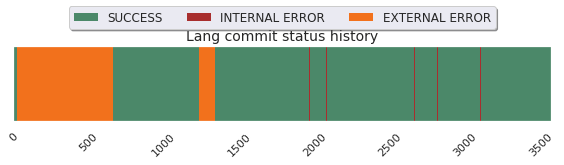

In [23]:
plot_and_save_histogram_advance(pa,1)